In [1]:
from fastai.text.all import *
import pandas as pd
cols = ["sentiment","text"]
df = pd.read_csv("data/all-data.csv", names =cols, encoding = "ISO-8859-1")
df_test = pd.read_csv("data/public-test-set.csv", names = cols, encoding = "ISO-8859-1")
df_all = pd.concat([df, df_test])

In [2]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning) 

In [3]:
#helper functions:
def gen_sentence(preface_text):
    N_WORDS = 50
    N_SENTENCES = 2
    preds = [learn.predict(preface_text, n_words = N_WORDS, temperature=0.75) 
             for _ in range(N_SENTENCES)]
    return("\n\n".join(preds))

In [4]:
def clean_text(in_df):
    #Remove words which have numbers in them
    in_df['text'] = in_df['text'].str.replace(r'\w*\d\w*', '')
    #Remove words which have special characters, except newline, space
    in_df['text'] = in_df['text'].str.replace(r'\w*[\$\#\&\@\~\*\%\;\/]\w*', '')

### Language Model

#### Train on an additional economic corpus

extra datasets for better language model:
https://github.com/philipperemy/financial-news-dataset
Ding et al. (2014)

In [5]:
n_to_read = 10000 #500 000
df_econ = pd.read_csv('data/bloomberg_out.zip', compression='zip', header=0, sep=',', quotechar='"')[-n_to_read:]
print(df_econ.shape)

(10000, 3)


In [6]:
clean_text(df_econ)
df_econ.head()

<ipython-input-4-758c5916f40e>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  in_df['text'] = in_df['text'].str.replace(r'\w*\d\w*', '')
<ipython-input-4-758c5916f40e>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  in_df['text'] = in_df['text'].str.replace(r'\w*[\$\#\&\@\~\*\%\;\/]\w*', '')


,date,filename,text
102692,2012-11-29,environmental-group-spotlights-rice-s-oil-sands-stakes,"Susan Rice ’s holdings in an energy\ncompany seeking State Department approval for an oil pipeline\nfrom Canada may pose a conflict of interest if she is nominated\nto become U.S. secretary of state. Rice, the U.S. ambassador to the United Nations, and her\nhusband own stock in TransCanada Corp. (TRP) valued at , to\n,, according to her most recent financial disclosure\n report . The company has filed for a State Department permit to\nbuild Keystone XL, a pipeline that would carry crude oil from\nAlberta’s oil sands to refineries on the U.S. Gulf coast. Rice also holds stock worth . mi..."
102693,2008-11-21,fidelity-owns-5-8-of-saizeriya-cuts-yamada-denki-update1-,"Nov. (Bloomberg) --Fidelity Investments Japan Ltd., a\nTokyo-based investment firm, held . percent of Saizeriya Co. () \nand cut its holding in Yamada Denki Co. () to . from .\npercent, according to filings today with Japan's Ministry of\nFinance. Fidelity and FMR LLC, its Boston-based affiliate, also\nchanged their holdings in other companies, according to\nseparate filings. \n \nCompany Name: Secom Techno Service Co.\nTicker Code: JP\nReport obligation incurred: Nov. \nShareholder: FMR LLC\n Shares Owned: ..."
102694,2010-01-22,credit-crisis-creates-lost-generation-david-g-blanchflower,"There is now a danger that the\nbiggest fallout from the credit crisis is the creation of a lost\ngeneration of young people who never make the transition from\nschool to work. \n The U.S. job figures for December weren’t good and much\nworse than most commentators had expected. Payrolls fell by\n, last month after a gain the previous month. \n About . million Americans left the workforce from July\nthrough December, a . percent drop and the biggest six-month\ndecrease since . The participation rate last month fell to\nthe lowest level in years. An exodus of discouraged workers\nfrom ..."
102695,2010-01-22,why-do-we-care-about-disruption-,"The other week, two of my colleagues were engaged in a fierce debate about whether a particular business was or not in fact ""disruptive."" When they asked my opinion, I surprised them by answering, ""I don't really care."" \n\n ""But we're all about disruptive innovation aren't we?"" one of them asked. \n\n ""Well yes,"" I replied, ""but we're all even more about building successful, sustainable, scalable businesses."" \n\n It's natural to think that our sole raison d'être is disruption. Innosight's co-founder Clayton Christensen coined the term ""disruptive technology,"" and we've built a busin..."
102696,2010-10-15,carrefour-france-telecom-natixis-pernod-sopra-french-equity-preview,"The following is a list of companies\nwhose shares may have unusual price changes in Paris. Stock\nsymbols are in parentheses after company names. Share prices are\nfrom the last close. The CAC Index rose . percent to ,. yesterday in\nParis. Air France-KLM Group (AF FP): Credit Suisse Group AG raised\nits recommendation for Europe’s largest airline to “neutral”\nfrom “underperform.” The stock increased . percent to .\neuros. Aeroports de Paris (ADP FP): The operator of the French\ncapital’s Charles de Gaulle and Orly airports said it had\nSeptember traffic of . million passengers, up..."


In [7]:
data_econ = TextDataLoaders.from_df(df_econ, is_lm=True, valid_pct = 0.1, text_col='text')
print(len(data_econ.vocab))
learn = language_model_learner(data_econ, AWD_LSTM, pretrained = True, drop_mult=0.5, metrics=[accuracy, Perplexity()], wd=0.1).to_fp16()

32848


SuggestedLRs(lr_min=0.03630780577659607, lr_steep=0.04786301031708717)

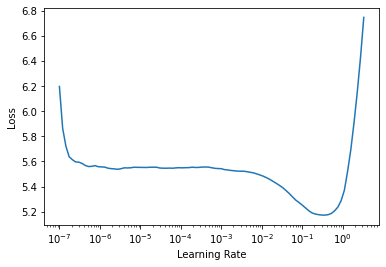

In [8]:
#learn.lr_find() #lr_steep=0.083176

In [9]:
print(gen_sentence("The company launched with"))

The company launched with a Company of Physicians , Medical Patients , and a Medical Crisis Unit ( PAIN ) in September , August and August , September of that year , a UN Commission on Emergency Care

The company launched with the European Union Union , the German company Des Moines Ring de France ( EA ) , in December of that year , the company operated in France and Switzerland . The company is seen as being


In [10]:
#learn.fit_one_cycle(1, 8e-2) #0.491
learn.fit(n_epoch=200, lr=5e-2, cbs=EarlyStoppingCallback(monitor='accuracy', min_delta=0.001, patience=5))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.046742,3.941957,0.315199,51.519302,04:08
1,3.961019,3.918523,0.317809,50.326038,04:08
2,4.001808,3.918427,0.320676,50.321224,04:08
3,3.966040,3.941689,0.319157,51.505535,04:06
4,3.981569,3.893301,0.322351,49.072586,04:06
5,4.071902,3.928588,0.317896,50.835155,04:08
6,3.979166,3.903210,0.322033,49.561306,04:07
7,4.063495,3.933284,0.315694,51.074444,04:08
8,4.007704,3.905459,0.322887,49.672859,04:06
9,3.987952,3.915366,0.322106,50.167450,04:07


No improvement since epoch 4: early stopping


In [11]:
#learn.save_encoder('lm_blmbrg_nightly_head')

In [12]:
learn.unfreeze()

In [13]:
#learn.lr_find() #lr_steep=9.999999747378752e-06

In [14]:
#learn.fit_one_cycle(5, 3e-5) #0.483
learn.fit(n_epoch=200, lr=slice(5e-3/(2.6**4),5e-3), cbs=EarlyStoppingCallback(monitor='accuracy', min_delta=0.001, patience=5))
learn.freeze()
#learn.save_encoder('lm_blmbrg_nightly_body')

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.153014,3.013430,0.427367,20.357107,04:36
1,3.008727,2.936853,0.438123,18.856411,04:35
2,2.930578,2.896875,0.445367,18.117443,04:36
3,2.876529,2.881521,0.447488,17.841393,04:37
4,2.809317,2.858087,0.452235,17.428148,04:38
5,2.881275,2.847013,0.455736,17.236225,04:38
6,2.794249,2.843694,0.455232,17.179104,04:38
7,2.713715,2.837992,0.457106,17.081434,04:39
8,2.655783,2.826458,0.459309,16.885542,04:38
9,2.727140,2.824354,0.460277,16.850063,04:37


No improvement since epoch 15: early stopping


In [15]:
learn.save_encoder('lm_blmbrg_nightly_body_enc')
learn.save('lm_blmbrg_nightly_body')

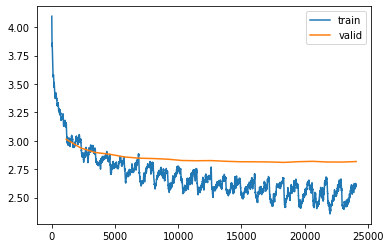

In [16]:
learn.recorder.plot_loss(with_valid = True)

In [17]:
print(gen_sentence("The company launched with"))

The company launched with a 
 partnership with Mitsubishi UFJ Financial Group Inc . to acquire 
 Sumitomo Heavy Industries Ltd . , a Japanese maker of goods 
 related to residential projects . Mitsubishi Heavy Industries Ltd . ,

The company launched with a 
 chairman at the Stockholm International Peace Talks Co. in a 
 bid to find a buyer , the Financial Times reported , without saying 
 where it got the information . The Swedish company will take years to expand


#### Finetune language model on train and test data
First load our challenge data:

In [45]:
clean_text(df_all)

<ipython-input-4-758c5916f40e>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  in_df['text'] = in_df['text'].str.replace(r'\w*\d\w*', '')
<ipython-input-4-758c5916f40e>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  in_df['text'] = in_df['text'].str.replace(r'\w*[\$\#\&\@\~\*\%\;\/]\w*', '')


In [46]:
data_lm = TextDataLoaders.from_df(df_all, is_lm=True, text_vocab = data_econ.vocab, valid_pct = 0.1, text_col='text', label_col="sentiment")
print(len(data_lm.vocab)) #

32848


Then let's extend vocab from pretrained economic LM with our new data:

In [47]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.5, metrics=[accuracy, Perplexity()], wd=0.1).to_fp16()
learn.load_encoder('lm_blmbrg_nightly_body_enc')
learn.load('lm_blmbrg_nightly_body')

SuggestedLRs(lr_min=0.025118863582611083, lr_steep=0.02290867641568184)

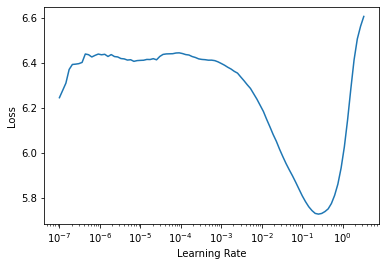

In [48]:
learn.lr_find() #lr_steep=0.0478630

In [49]:
learn.fit_one_cycle(1, 4e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.469747,3.975424,0.316982,53.272701,00:14


In [50]:
learn.unfreeze()

SuggestedLRs(lr_min=0.0002511886414140463, lr_steep=1.3182567499825382e-06)

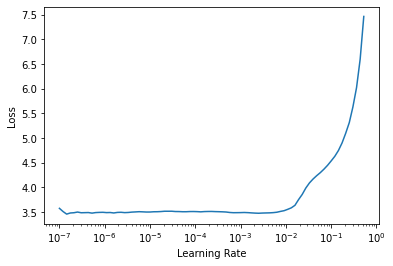

In [51]:
learn.lr_find() #lr_steep=3.981071586167673e-06

In [52]:
learn.fit_one_cycle(1, 4e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.518885,3.759420,0.348761,42.923531,00:15


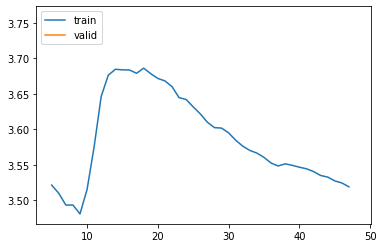

In [53]:
learn.recorder.plot_loss(with_valid = True)

In [54]:
learn.freeze()
learn.save_encoder('lme_blmbrg_finetuned_enc')
learn.save('lme_blmbrg_finetuned')

#### Check generative performance

In [55]:
print(gen_sentence("The company launched with"))

The company launched with Alma Media Corporation to acquire the Ultra Pro s Market Class Magazine Suite , located in Helsinki , in Helsinki , Finland . i believe i am why i believe this stock is worth feel good for

The company launched with the Finnish Lamarre General Meeting , the Finnish Le Centre is a subsidiary of Nordea Bank Finland Plc , Nordea Bank ( STO : STO ) , Nordea Bank AB ,
